In [ ]:
# toc

# imports

In [145]:
import pickle
import pandas as pd
import seaborn
import plotly.express as px

from joblib import Memory
from matplotlib import pyplot as plt
from nilearn.connectome import ConnectivityMeasure
import numpy as np
from pyriemann.utils.mean import mean_riemann
from brainspace.gradient import GradientMaps

from gradecc.compute.conn_mat.center import center_cmat
# Dan's

from gradecc.load_data import Timeseries
# loads data from file to pd.df

from brainspace.datasets import load_conte69
from brainspace.utils.parcellation import map_to_labels
import nibabel
from surfplot import Plot


SUBJECTS_INT = [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
                23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 35, 36, 38, 40, 41, 44, 45, 46]
EPOCHS = ['baseline', 'early', 'late']
EPOCH_REF = 'baseline'

APR='pca'
RANS=0

# utils

In [146]:
# to cache a function on disk
mem = Memory('.')

dir = './cache/'

def dump(a, fname):
    with open(dir+fname+'.pkl', 'wb') as handle:
        pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load(fname):
    with open(dir+fname+'.pkl', 'rb') as handle:
        return pickle.load(handle)

# timeseries

In [147]:
sample_ts = Timeseries(subject=2, epoch='baseline')
sample_ts.load()
sample_ts.data

,7Networks_LH_Vis_1,7Networks_LH_Vis_2,7Networks_LH_Vis_3,7Networks_LH_Vis_4,7Networks_LH_Vis_5,7Networks_LH_Vis_6,7Networks_LH_Vis_7,7Networks_LH_Vis_8,7Networks_LH_Vis_9,7Networks_LH_Vis_10,...,Right VIIIa,Left VIIIb,Vermis VIIIb,Right VIIIb,Left IX,Vermis IX,Right IX,Left X,Vermis X,Right X
3,0.619059,0.212399,-0.397736,-0.019531,-0.375093,-0.260682,0.813853,-0.097351,-0.211968,0.341829,...,0.787102,0.045657,0.692766,0.116574,-0.694965,-0.669235,0.321611,-0.714039,0.645568,-0.548769
4,0.925779,-0.954917,-0.258214,-0.649791,0.379977,-0.625451,-0.145867,0.184408,-0.680507,-0.382208,...,0.128971,0.148791,0.152312,-1.159273,0.528155,0.635899,-1.205409,0.676500,0.085890,0.047503
5,0.626875,-0.989889,-0.161264,-1.004715,0.412673,-0.759415,-0.606122,-0.048508,-0.729473,-0.758798,...,-1.041844,-0.619600,-1.005859,-0.998181,-0.595157,-1.101287,-1.257779,-0.985447,-0.847289,-0.228887
6,0.291048,-0.183669,-0.235433,-0.797872,-0.397722,-0.705493,-0.242141,-0.720461,-0.297353,-0.457756,...,-0.859729,0.554819,-0.492801,1.298689,0.689845,0.005797,-0.190183,0.610956,-0.000497,0.721711
7,0.399648,0.237355,-0.366008,-0.403004,-1.052488,-0.647728,0.201340,-1.234412,0.199633,0.074474,...,0.275050,-1.430377,1.747600,-0.308219,-0.489006,1.022842,0.992858,-0.392210,0.574385,-0.375016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,-0.146590,1.521479,0.649142,-0.271221,0.141444,1.108605,-0.443911,-0.021621,-0.006362,-0.437139,...,-0.292085,1.374837,0.820518,0.514357,1.016304,0.880243,1.890717,1.528671,-0.255163,0.325893
215,-0.205213,-0.125841,-0.605073,-0.945500,-0.438729,0.360575,-0.533365,-0.923990,-0.418029,-0.167742,...,0.841928,0.819967,-0.379003,0.564662,1.756883,2.004688,2.105934,0.657847,0.748752,1.317683
216,-0.054129,-1.571816,-1.382739,-1.249235,-0.832187,-0.486080,-0.443039,-1.407017,-0.874403,0.214144,...,0.781670,-0.139723,-0.469562,0.278206,0.778243,1.449812,1.326075,0.214427,0.605848,0.233798
217,-0.143634,-0.984511,-0.740617,-0.905064,-0.714287,-0.829367,-0.137792,-0.784766,-0.641033,-0.051187,...,-0.257333,-1.375125,0.183924,-1.309316,-0.088991,0.827189,0.126521,0.434710,0.625600,-0.600772


# conn mat
covariance

In [6]:
def cmat(ts: Timeseries, fill_diag=False, kind='covariance') -> np.ndarray:
    if ts.data is None: ts.load()
    conn_measure = ConnectivityMeasure(kind=kind)
    cmat = conn_measure.fit_transform([ts.data.to_numpy()])[0]
    if fill_diag:   np.fill_diagonal(cmat, 0)
    return cmat

In [7]:
cmat(Timeseries(1, 'baseline'))

array([[ 1.00787953,  0.23300753,  0.50633092, ...,  0.04168037,
        -0.12909226,  0.032568  ],
       [ 0.23300753,  1.00791613,  0.23761153, ...,  0.06854963,
        -0.1366801 ,  0.1801675 ],
       [ 0.50633092,  0.23761153,  0.9992181 , ...,  0.03359876,
         0.02517184,  0.11424387],
       ...,
       [ 0.04168037,  0.06854963,  0.03359876, ...,  1.00198158,
         0.13651203,  0.20046535],
       [-0.12909226, -0.1366801 ,  0.02517184, ...,  0.13651203,
         1.00459698,  0.047801  ],
       [ 0.032568  ,  0.1801675 ,  0.11424387, ...,  0.20046535,
         0.047801  ,  1.00519787]])

for mats, distribution of diagonal values are shown.

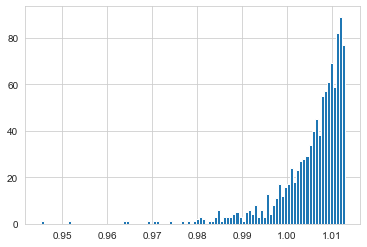

In [8]:
plt.hist(np.diag(_), bins=100)
plt.show()

# center mat

In [11]:
print(SUBJECTS_INT)

[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 35, 36, 38, 40, 41, 44, 45, 46]


In [12]:
EPOCHS

['baseline', 'early', 'late']

In [13]:
# grand_mean = mean_riemann(
#         np.stack([cmat(Timeseries(s, e))
#                   for e in EPOCHS for s in SUBJECTS_INT]),
#     maxiter=5)
#
# dump(grand_mean, 'grand_mean_iter5')

# get riemann mean of all mats
grand_mean = load('grand_mean_iter5')

In [14]:
grand_mean

array([[0.16378138, 0.01275667, 0.0134736 , ..., 0.00386107, 0.00217978,
        0.00450187],
       [0.01275667, 0.15615674, 0.0224449 , ..., 0.00591451, 0.00255782,
        0.00573476],
       [0.0134736 , 0.0224449 , 0.16030768, ..., 0.00596199, 0.00261473,
        0.00506538],
       ...,
       [0.00386107, 0.00591451, 0.00596199, ..., 0.51607051, 0.06587699,
        0.14030197],
       [0.00217978, 0.00255782, 0.00261473, ..., 0.06587699, 0.5348349 ,
        0.05112269],
       [0.00450187, 0.00573476, 0.00506538, ..., 0.14030197, 0.05112269,
        0.51443634]])

distribution of diagonal values are shown.

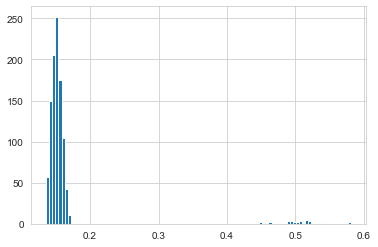

In [15]:
plt.hist(np.diag(grand_mean), bins=100)
plt.show()

In [16]:
# riemann mean of each subject. cached on disk with mem.cache
@mem.cache
def subj_mean(subject):
    return  mean_riemann(np.stack([
        cmat(Timeseries(subject, e)) for e in EPOCHS]), maxiter=5)

## compare centered vs not

In [17]:
c1 = cmat(Timeseries(1, 'early'))
c1

array([[ 1.21933276,  0.7151146 ,  0.55243186, ...,  0.26788957,
        -0.01723554,  0.16986816],
       [ 0.7151146 ,  1.25696243,  0.68387336, ...,  0.25763842,
        -0.05759605,  0.24000709],
       [ 0.55243186,  0.68387336,  1.17811635, ...,  0.30843265,
         0.17739462,  0.21476946],
       ...,
       [ 0.26788957,  0.25763842,  0.30843265, ...,  0.98947952,
         0.19379536,  0.51059608],
       [-0.01723554, -0.05759605,  0.17739462, ...,  0.19379536,
         1.15014879,  0.16395357],
       [ 0.16986816,  0.24000709,  0.21476946, ...,  0.51059608,
         0.16395357,  1.06348801]])

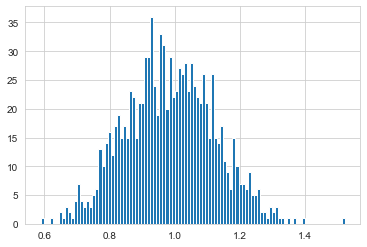

In [18]:
plt.hist(np.diag(_), bins=100)
plt.show()

In [19]:
center_cmat(c1, subj_mean(1), grand_mean)

array([[0.39898198, 0.1640771 , 0.12689111, ..., 0.06537281, 0.01570356,
        0.04411934],
       [0.1640771 , 0.37573711, 0.17997445, ..., 0.06698158, 0.03099819,
        0.06633237],
       [0.12689111, 0.17997445, 0.39024098, ..., 0.08139321, 0.06058   ,
        0.04809958],
       ...,
       [0.06537281, 0.06698158, 0.08139321, ..., 0.62868608, 0.126743  ,
        0.25494809],
       [0.01570356, 0.03099819, 0.06058   , ..., 0.126743  , 0.72507699,
        0.08844958],
       [0.04411934, 0.06633237, 0.04809958, ..., 0.25494809, 0.08844958,
        0.69187942]])

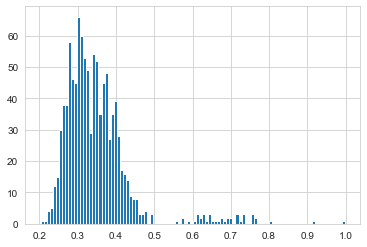

In [20]:
plt.hist(np.diag(_), bins=100)
plt.show()

## reference mat
riemann mean of all subjects in this ref epoch.

In [21]:
EPOCH_REF

'baseline'

In [22]:
# ref_cmat = mean_riemann(
#     np.stack([cmat(Timeseries(s, EPOCH_REF)) for s in SUBJECTS_INT]),
#     maxiter=5)
#
# dump(ref_cmat, 'ref_cmat')

ref_cmat = load('ref_cmat')

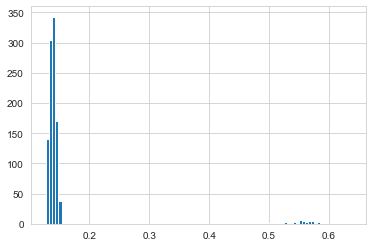

In [23]:
plt.hist(np.diag(ref_cmat), bins=100)
plt.show()

# grads
## ref grads
we need a reference gradient to align others to it.

In [24]:
# how to dimension reduction. approach.
APR

'pca'

**if you don't apply cosine kernel while making affinity mat, you get way skewed gradient values.**

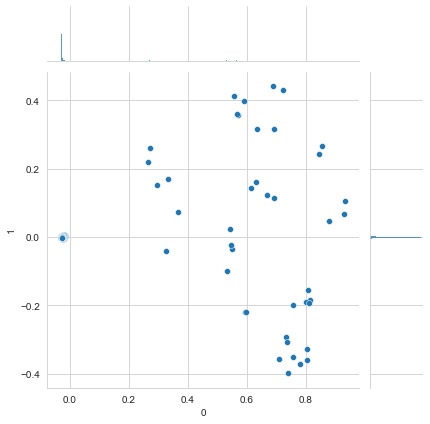

In [149]:
gref_nokernel = GradientMaps(random_state=RANS, approach=APR)
gref_nokernel.fit(ref_cmat)
seaborn.jointplot(data=pd.DataFrame(gref_nokernel.gradients_), x=0, y=1)
plt.show()

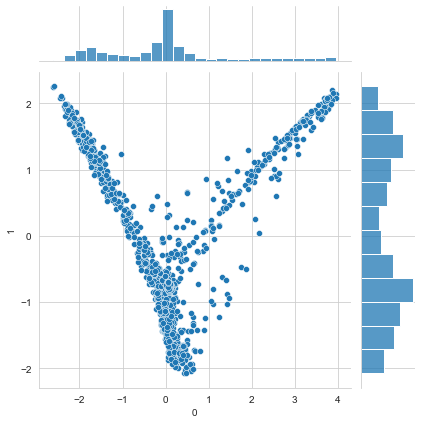

In [150]:
gref = GradientMaps(random_state=RANS, approach=APR, kernel='cosine')
gref.fit(ref_cmat)
seaborn.jointplot(data=pd.DataFrame(gref.gradients_), x=0, y=1)
plt.show()

## all subject-epoch pairs

by default, it computes top **10** gradients for **1040** brain regions (including subcortex/cerebellum) for 3 epochs * 38 subjects (=**114**)

In [32]:
g = GradientMaps(random_state=RANS, approach=APR, alignment='procrustes', kernel='cosine')
g.fit([center_cmat(cmat(Timeseries(s, e)), subj_mean(s), grand_mean)
       for e in EPOCHS for s in SUBJECTS_INT],
          reference=gref.gradients_)

assert len(g.aligned_) == len(EPOCHS) * len(SUBJECTS_INT)
np.stack(g.aligned_).shape

(114, 1040, 10)

In [263]:
np.stack(g.aligned_)

array([[[ 0.48040445, -0.26370272,  2.18038683, ..., -0.86264191,
          0.30548494,  0.19941093],
        [ 0.57392648,  1.4031778 ,  1.02001049, ..., -0.23706948,
          0.89257156, -0.18013862],
        [ 0.29158999,  0.66214728,  1.62819739, ..., -0.97261771,
          0.80626982,  0.24136247],
        ...,
        [ 0.60379701, -0.5526683 ,  2.60107081, ..., -0.52949211,
         -0.34091729, -0.04862711],
        [ 0.50590791, -1.1056062 ,  1.91471062, ..., -0.8876298 ,
         -0.25061114,  0.22942264],
        [ 0.62166679, -0.40623783,  2.73884226, ..., -0.56418366,
         -0.23076983,  0.08419834]],

       [[-0.05759292,  0.1734546 ,  0.84296931, ...,  0.02204941,
          0.99551826, -0.11346991],
        [-0.83662126,  1.50504391,  0.47449946, ...,  0.26541118,
         -0.03147341,  0.44698051],
        [-0.08292653,  1.70760907,  0.43964112, ..., -0.58363694,
          1.06286862,  1.09253782],
        ...,
        [-0.03147509, -0.94295724,  2.26810146, ...,  

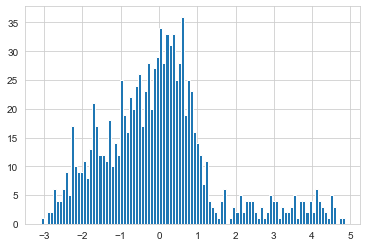

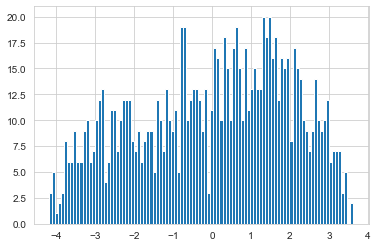

In [185]:
plt.hist(g.aligned_[0][:, 0], bins=100) # grad1
plt.show()
plt.hist(g.aligned_[0][:, 1], bins=100) # grad2
plt.show()

## regions and labels
put regions into number of clusters/modules/networks for visualization purpose.

In [180]:
# region names
region_names = sample_ts.data.columns.tolist()
len(region_names)

1040

In [199]:
labels = pd.Series(region_names)
labels = labels.apply(lambda x: x.split(' ')[0]+'SubC' if ' ' in x   # subcortical regions
            else x[10:].split('_')[1]+'Cort')    # cortical regions
labels = labels.rename('label')
print(labels.shape)
print(labels.unique())

(1040,)
['VisCort' 'SomMotCort' 'DorsAttnCort' 'SalVentAttnCort' 'LimbicCort'
 'ContCort' 'DefaultCort' 'LeftSubC' 'RightSubC' 'VermisSubC']


# dataframe
make pd.DataFrame to organize data for plotting and doing stats.

In [174]:
# important: this is how the g.aligned_ list is organized
S = [1,2]
l = [(s, e) for e in EPOCHS for s in S]
print(l)
# select element for s=2, e='late'
l[EPOCHS.index('late') * len(S) + S.index(2)]

[(1, 'baseline'), (2, 'baseline'), (1, 'early'), (2, 'early'), (1, 'late'), (2, 'late')]


(2, 'late')

In [227]:
df = pd.concat([pd.DataFrame({'subject': s, 'epoch': e, 'region': region_names, 'label': labels,
               'g1': g.aligned_[EPOCHS.index(e) * len(SUBJECTS_INT) + SUBJECTS_INT.index(s)][:, 0],
               'g2': g.aligned_[EPOCHS.index(e) * len(SUBJECTS_INT) + SUBJECTS_INT.index(s)][:, 1],
               'g3': g.aligned_[EPOCHS.index(e) * len(SUBJECTS_INT) + SUBJECTS_INT.index(s)][:, 2],
               'g4': g.aligned_[EPOCHS.index(e) * len(SUBJECTS_INT) + SUBJECTS_INT.index(s)][:, 3],})
           for e in EPOCHS for s in SUBJECTS_INT], axis=0).reset_index(drop=True)

In [228]:
# we took only top 4 gradients
assert df.shape[0] == len(SUBJECTS_INT) * len(EPOCHS) * len(region_names)
df

,subject,epoch,region,label,g1,g2,g3,g4
0,1,baseline,7Networks_LH_Vis_1,VisCort,0.480404,-0.263703,2.180387,0.402468
1,1,baseline,7Networks_LH_Vis_2,VisCort,0.573926,1.403178,1.020010,-0.193533
2,1,baseline,7Networks_LH_Vis_3,VisCort,0.291590,0.662147,1.628197,-0.588381
3,1,baseline,7Networks_LH_Vis_4,VisCort,2.352881,2.066208,0.201950,0.252048
4,1,baseline,7Networks_LH_Vis_5,VisCort,0.388140,0.618736,1.054415,-0.233904
...,...,...,...,...,...,...,...,...
118555,46,late,Vermis IX,VermisSubC,-0.427469,-0.480867,2.758838,3.350099
118556,46,late,Right IX,RightSubC,-0.001993,-0.173274,2.976064,3.083490
118557,46,late,Left X,LeftSubC,0.033317,-0.974091,3.004128,2.663435
118558,46,late,Vermis X,VermisSubC,1.201635,-0.963183,2.926164,2.514043


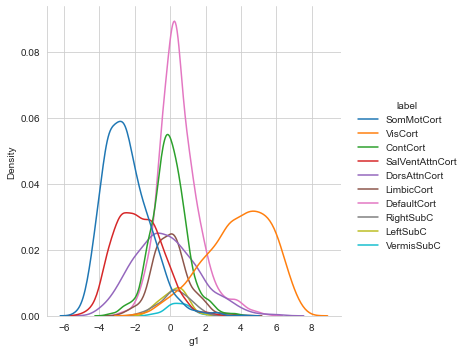

In [217]:
seaborn.displot(df.sample(10_000), x='g1', hue='label', kind='kde')
plt.show()

In [221]:
# this can be less noisy if we average values per region. this is a sample not the mean.
fig = px.scatter_3d(df.sample(1000), x='g1', y='g2', z='g3', color='label', opacity=.4)
fig.update_traces(marker_size=3)
fig.show()

# eccentricity
the Euclidean distance from the manifold center.
$Ecc = \sqrt{\sum_{\substack{i=1}}^4 G_i^2}$

In [235]:
df['ecc'] = df.apply(lambda r: np.sqrt(np.sum(g**2 for g in r[-4:])), axis=1)

# average

In [359]:
df_mean = df.groupby(['region', 'epoch', 'label']).agg('mean').drop('subject', axis=1).reset_index()
df_mean

,region,epoch,label,g1,g2,g3,g4,ecc
0,7Networks_LH_Cont_Cing_1,baseline,ContCort,-1.565833,-0.260466,-0.018797,0.247138,2.087431
1,7Networks_LH_Cont_Cing_1,early,ContCort,-1.561825,-0.115076,-0.452926,0.411971,2.403753
2,7Networks_LH_Cont_Cing_1,late,ContCort,-1.671688,-0.004962,-0.270194,0.663446,2.368376
3,7Networks_LH_Cont_Cing_2,baseline,ContCort,0.461848,-1.728179,-1.327698,-0.221124,2.682874
4,7Networks_LH_Cont_Cing_2,early,ContCort,0.394512,-1.644827,-1.518582,0.189363,2.541156
...,...,...,...,...,...,...,...,...
3115,Vermis VIIb,early,VermisSubC,0.530325,-0.446890,2.450830,1.784687,3.275516
3116,Vermis VIIb,late,VermisSubC,0.560011,-0.527465,2.322758,1.736446,3.228443
3117,Vermis X,baseline,VermisSubC,0.356602,-1.070557,2.205049,1.721528,3.187850
3118,Vermis X,early,VermisSubC,0.607545,-0.864725,1.827519,1.622528,2.899026


# plot on brain

In [323]:
# caution: `groupby` changes regions' ordering. This doesn't start with `LH_Vis`
df_mean = df_mean.set_index('region').loc[pd.Series(region_names)].reset_index()
df_mean.head()

,region,epoch,label,g1,g2,g3,g4,ecc
0,7Networks_LH_Vis_1,baseline,VisCort,0.752718,0.176407,0.680963,0.083991,1.985498
1,7Networks_LH_Vis_1,early,VisCort,0.610513,-0.162555,0.759171,0.564994,1.879671
2,7Networks_LH_Vis_1,late,VisCort,0.277102,-0.310652,0.383196,0.675228,1.748320
3,7Networks_LH_Vis_2,baseline,VisCort,1.386640,1.247141,0.796006,-0.195546,2.737319
4,7Networks_LH_Vis_2,early,VisCort,1.101239,1.232960,0.938798,-0.054804,2.512791


In [307]:
fname = '/Users/qasem/PycharmProjects/gradients-rl-task/data/Schaefer2018_1000Parcels_7Networks_order.dlabel.nii'
l_hemi, r_hemi = load_conte69()
vertices = nibabel.load(fname).get_fdata()[0]

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


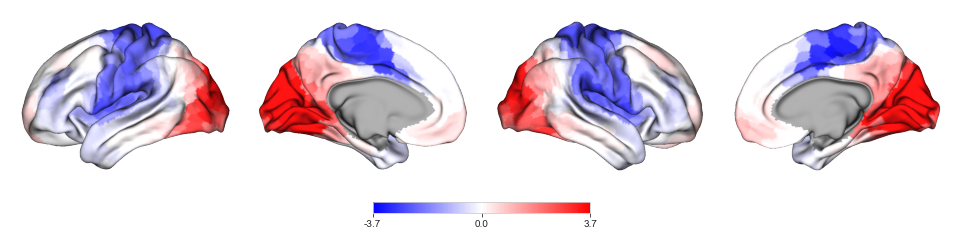

In [319]:
data = df_mean[df_mean.epoch=='baseline'].reset_index()['g1']
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='row', size=(1600, 300))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-3.7, 3.7))
_ = p.build()

<AxesSubplot:>

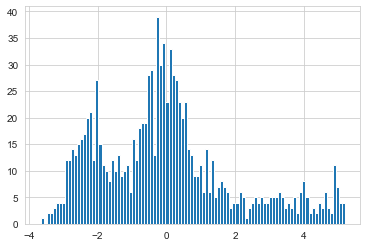

In [358]:
df_mean.loc[df_mean.epoch=='baseline', 'g1'].hist(bins=100)

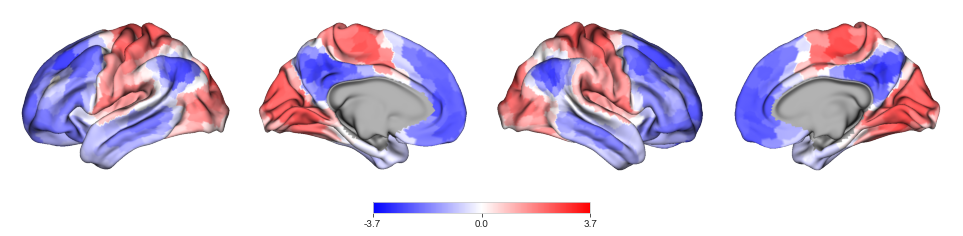

In [320]:
data = df_mean[df_mean.epoch=='baseline'].reset_index()['g2']
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='row', size=(1600, 300))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-3.7, 3.7))
_ = p.build()

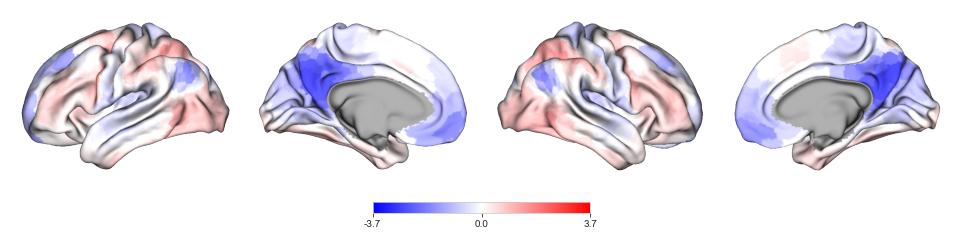

In [321]:
data = df_mean[df_mean.epoch=='baseline'].reset_index()['g3']
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='row', size=(1600, 300))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-3.7, 3.7))
_ = p.build()

# stats

## ttests
compare ecc values between epochs. False discovery rate (FDR) correction applied.

In [380]:
import pingouin as pg

dfp = df.groupby(['region', 'label']).apply(pg.pairwise_ttests, dv='ecc', between='epoch',
                                            subject='subject', padjust='fdr_bh')

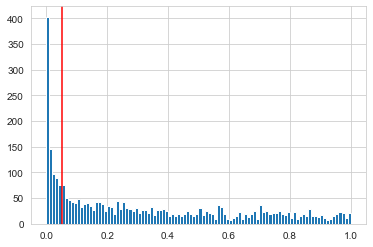

In [381]:
dfp['p-corr'].hist(bins=100) # corrected p value
plt.axvline(x=.05, color='red') # type-I error
plt.show()

In [382]:
# epoch pairs set to be index
dfp = dfp.reset_index()[['region', 'label', 'A', 'B', 'T', 'p-unc', 'p-corr']]
dfp = dfp.set_index('region').loc[pd.Series(region_names)].reset_index().set_index(['A', 'B'])

In [384]:
dfp.loc[('baseline', 'early')]

region       label         T     p-unc    p-corr
A        B                                                                  
baseline early  7Networks_LH_Vis_1     VisCort  0.605601  0.546632  0.546632
         early  7Networks_LH_Vis_2     VisCort  0.991298  0.324770  0.324770
         early  7Networks_LH_Vis_3     VisCort  0.894901  0.373742  0.560612
         early  7Networks_LH_Vis_4     VisCort  0.191607  0.848575  0.848575
         early  7Networks_LH_Vis_5     VisCort -1.631610  0.107011  0.107011
...                            ...         ...       ...       ...       ...
         early           Vermis IX  VermisSubC  1.687630  0.095693  0.232486
         early            Right IX   RightSubC  1.388896  0.169030  0.253546
         early              Left X    LeftSubC  2.151185  0.034726  0.052089
         early            Vermis X  VermisSubC  1.859828  0.066884  0.200653
         early             Right X   RightSubC  1.747210  0.084749  0.127124

[1040 rows x 5 columns]

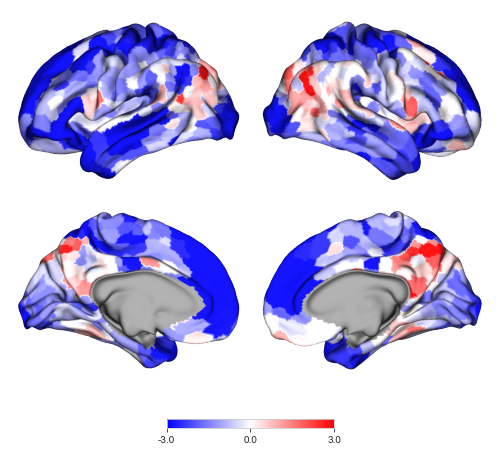

In [394]:
data = dfp.loc[('baseline', 'early')].reset_index()['T']
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-3, 3))
_ = p.build()

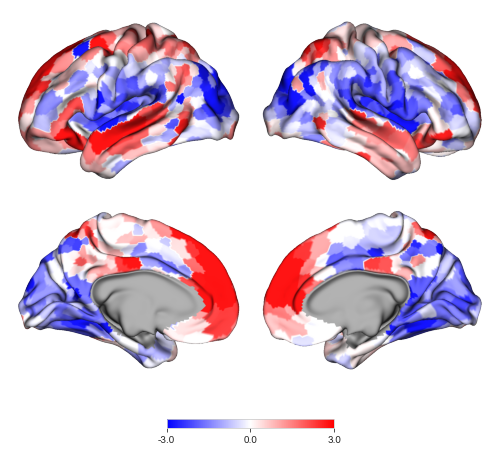

In [393]:
data = dfp.loc[('early', 'late')].reset_index()['T']
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-3, 3))
_ = p.build()

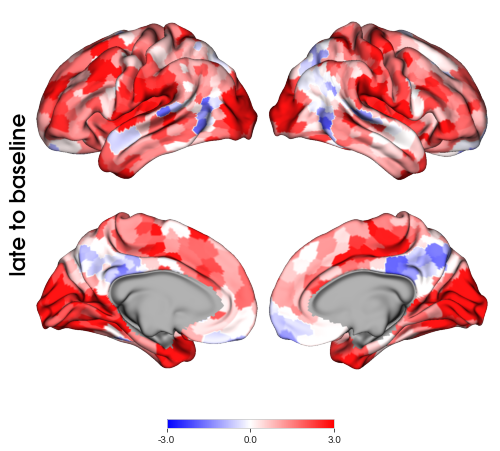

In [399]:
data = -1 * dfp.loc[('baseline', 'late')].reset_index()['T']
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700), label_text=['late to baseline'])
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-3, 3))
_ = p.build()

## anova
repeated measures

In [402]:
dfa = df.groupby(['region', 'label']).apply(pg.rm_anova, dv='ecc',
                                      within='epoch', subject='subject')

In [436]:
_, dfa['p-corr'] = pg.multicomp(dfa['p-unc'], method='fdr_bh')

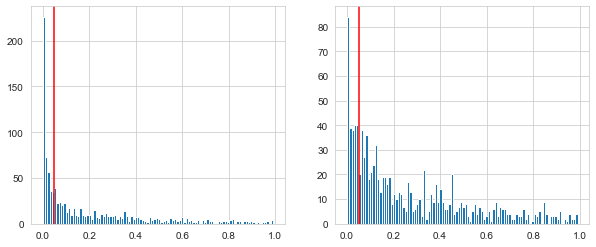

In [445]:
_, ax = plt.subplots(ncols=2, figsize=(10,4))
dfa['p-unc'].hist(bins=100, ax=ax[0]) # uncorrected p value
ax[0].axvline(x=.05, color='red') # type-I error
dfa['p-corr'].hist(bins=100, ax=ax[1]) # corrected p value
ax[1].axvline(x=.05, color='red') # type-I error
plt.show()

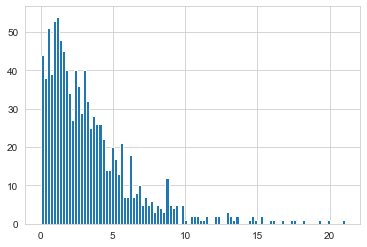

In [412]:
dfa['F'].hist(bins=100)
plt.show()

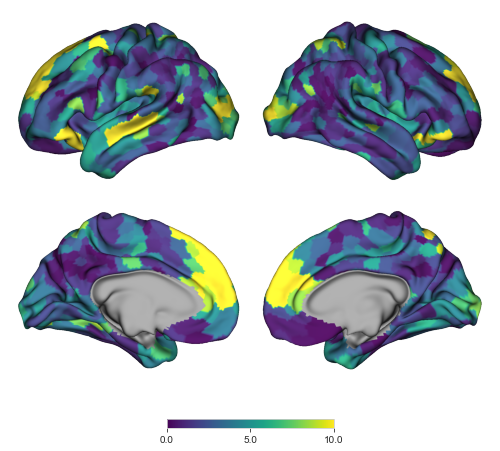

In [438]:
data = dfa.loc[pd.Series(region_names)]['F']
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data, cbar=True, cmap='viridis', color_range=(0, 10))
_ = p.build()

masked with p value corrected

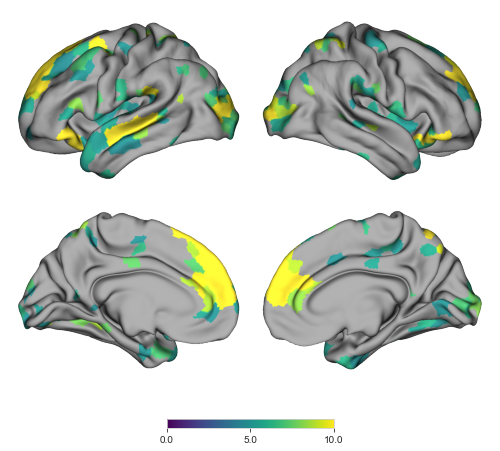

In [439]:
data = dfa.loc[pd.Series(region_names)]
data = data.apply(lambda r: r['F'] if r['p-corr'] < 0.05 else None, axis=1).values
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700))
p.add_layer(data, cbar=True, cmap='viridis', color_range=(0, 10))
_ = p.build()
